In [5]:
# import rasterio as rs
import xarray as xr
# import numpy as np
# import cartopy.crs as ccrs
# import cartopy
# import matplotlib.pyplot as plt
# import urllib
import glob
# import shutil
import geopandas
# import shapely
import rioxarray
from shapely.geometry import mapping
# import torch
# import time

In [27]:
def clip2colorado(raster,basin):
    rast = rioxarray.open_rasterio(raster,engine="rasterio")
    r_clip = rast.rio.clip(basin.geometry.apply(mapping),basin.crs)
    r_clip_nonans = np.where(r_clip[0]<0,np.nan,r_clip[0])
    # plt.imshow(r_clip_nonans)
    r_clip.to_netcdf('smap_ee_color_smp/color_{}.nc'.format(raster[34:51]))
    
    r_clip_meta = xr.open_dataset('smap_ee_color_smp/color_{}.nc'.format(raster[34:51]))
    r_clip_meta = r_clip_meta.rename({'__xarray_dataarray_variable__':'sm_profile'})
    #keep it to single lines for attributes
    r_clip_meta.attrs = {}
    r_clip_meta.attrs['sm_profile'] = "ratio of water to soil optically obtained from SMAP with filtering included" 
    r_clip_meta.attrs['sm_profile_units'] = "%"
    r_clip_meta.attrs['sm_pro_source'] = "https://developers.google.com/earth-engine/datasets/catalog/NASA_USDA_HSL_SMAP10KM_soil_moisture#citations"
    
    r_clip_meta.to_netcdf('smap_ee_color_smp/metadata/colorado_{}.nc'.format(raster[34:51]))
    
    return r_clip,r_clip_nonans

basin = geopandas.read_file('colorado/CRBasin_PacificInstitute.shp')

smap_soilmoistureprofile_tensor = glob.glob('smap_smp_ee/tifs/*.tif')
for idx,raster in enumerate(smap_soilmoistureprofile_tensor):
    clip2colorado(raster,basin)

In [30]:
# clip2colorado(smap_soilmoistureprofile_tensor[0],basin);

In [28]:
clipped_smp = xr.open_dataset('smap_ee_color_smp/metadata/colorado_20190420_20190422.nc')
clipped_smp

<xarray.Dataset>
Dimensions:      (band: 1, x: 81, y: 133)
Coordinates:
  * y            (y) float64 43.36 43.27 43.17 43.08 ... 31.27 31.17 31.08 30.98
  * x            (x) float64 -116.9 -116.8 -116.6 ... -106.0 -105.8 -105.7
  * band         (band) int64 1
Data variables:
    spatial_ref  int64 ...
    sm_profile   (band, y, x) float32 ...
Attributes:
    sm_profile:        ratio of water to soil optically obtained from SMAP wi...
    sm_profile_units:  %
    sm_pro_source:     https://developers.google.com/earth-engine/datasets/ca...

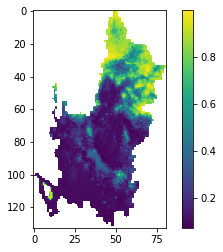

In [38]:
plt.imshow(np.where((clipped_smp.sm_profile>0) & (clipped_smp.sm_profile<1) == True,clipped_smp.sm_profile,np.nan)[0])
plt.colorbar()

In [3]:
import time
import glob
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split, Subset
from torchvision import transforms, models

# from random import choice
# from torch.utils.data import random_split
# from sklearn.metrics import mean_squared_error
# import pytorch_ssim
# import arrow
from torchinfo import summary
from datetime import datetime
from pytz import timezone
import scipy.ndimage
east = timezone('US/Eastern')

In [4]:
def nc2torch(i):
    return torch.from_numpy(np.asarray(i)).unsqueeze(0)

# m = xr.open_dataset('smap_ee_miss_smp_metadata/miss_20190505_20190507.nc')
# w = xr.open_dataset('smap_ee_miss_smp_metadata/miss_20150402_20150404.nc')
# m1 = nc2torch(m.sm_profile)
# w1 = nc2torch(w.sm_profile)

In [5]:
# x = glob.glob('smap_ee_color_smp/metadata/*.nc')
# xx = xr.open_dataset(x[0])
# print(xx.x.shape[0])

# dset = torch.empty([0,1,xx.y.shape[0],xx.x.shape[0]])
# t2 = []

# for x in sorted(glob.glob('smap_ee_color_smp/metadata/*.nc')):
#     t0 = time.time()
#     y = xr.open_dataset(x)
#     z = nc2torch(y.sm_profile)
#     dset = torch.cat((dset,z))
#     t1 = time.time()
#     t2.append(t1-t0)
# #     break
# dset.shape

# torch.save(dset,'colorado_imz.pt')

# x = torch.load('colorado_imz.pt')
# print('colorado images shape',x.shape)

# zscored_imz = []
# for idy,y in enumerate(x):
#     y = y.numpy()
#     y = np.where((y>0) & (y<1) == True,y,np.nan)
#     np_nanmean = np.nanmean(y)
#     np_nanstd = np.nanstd(y)
#     zscored = (y-np_nanmean)/np_nanstd
#     zscored = np.where(np.isfinite(zscored) == False, 0, zscored)
#     zscored_imz.append(zscored)
# zscored_imz = torch.from_numpy(np.asarray(zscored_imz))
# print(type(zscored_imz))

# torch.save(zscored_imz,'zscored_colorado_imz.pt')

# plt.imshow(zscored_imz[0,0],cmap='jet')
# plt.colorbar()



torch.cuda.empty_cache()
torch.cuda.current_device()
print(torch.cuda.device_count())
print(torch.cuda.get_device_name(0))

class setter(Dataset):
    def __init__(self,x,y,z):
        self.xog = torch.load(x)[:z]
        self.yog = torch.load(y)[:z]
        self.std,self.mean = torch.std_mean(self.yog)

        print('std',self.std)
        
        self.yog = (self.yog - self.mean)/self.std
        print(self.yog[0])
        
        print('shape of x',self.xog.shape)
        print('shape of y',self.yog.shape)
        
        self.x = self.xog.reshape(self.xog.shape[0],self.xog.shape[2]*self.xog.shape[3])
        self.y = self.yog.reshape(self.yog.shape[0],self.yog.shape[3])
#         rand_pts = torch.from_numpy(np.random.randint(0,self.x.shape[0],1000))
#         self.x = self.x[rand_pts]
#         self.y = self.y[rand_pts]
    def __getitem__(self,idx):
        x = self.x[idx].to('cuda')
#         x -= torch.min(x)
#         x /= torch.max(x)
        y = self.y[idx].to('cuda')
#         y -= torch.min(y)
#         y /= torch.max(y)
        return x, y
    def __len__(self):
        return self.x.shape[0]

class MLP(torch.nn.Module):
    def __init__(self,im_height,im_width):
        super(MLP,self).__init__()
        self.fci = torch.nn.Linear(im_height * im_width,60)
        self.fco = torch.nn.Linear(60,1)
        self.relu = torch.nn.ReLU()
        self.sigmoid = torch.nn.Sigmoid()
        # self.dropout = torch.nn.Dropout(0.5)

    def forward(self,x):
        x = self.relu(self.fci(x.view(x.size(0),-1)))
        x = self.fco(x)
        return x

class setter2(Dataset):
    def __init__(self,x,y,z):
        self.x = torch.load(x)[:z]
        self.y = torch.load(y)[:z]
        
        
        self.std,self.mean = torch.std_mean(self.y)
        
        
        #gets rid of values outside 95% statistical confidence interval. 
        #this is not an anomaly detection system it's for looking @ predictability.
        self.ninetyfive_confidence = []
        for idx,i in enumerate(self.y):
            if (self.y >= self.mean + self.std) | (self.y < self.mean - self.std) == True:
                self.ninetyfive_confidence.append(False)
            else:
                self.ninetyfive_confidence.append(True)
        self.ninetyfive_confidence = np.asarray(self.ninetyfive_confidence)
        
        self.x = self.x[self.ninetyfive_confidence]
        self.y = self.y[self.ninetyfive_confidence]

#         print('std',self.std)
        
        self.y = (self.y - self.mean)/self.std
#         print(self.y[0])


        print('shape of x',self.x.shape)
        print('shape of y',self.y.shape)
        
        # self.x = self.xog.reshape(self.xog.shape[0],self.xog.shape[2]*self.xog.shape[3])
        self.y = self.y.reshape(self.y.shape[0],self.y.shape[3])
#         rand_pts = torch.from_numpy(np.random.randint(0,self.x.shape[0],1000))
#         self.x = self.x[rand_pts]
#         self.y = self.y[rand_pts]
    def __getitem__(self,idx):
        x = self.x[idx].to('cuda')
#         x -= torch.min(x)
#         x /= torch.max(x)
        y = self.y[idx].to('cuda')
#         y -= torch.min(y)
#         y /= torch.max(y)
        return x, y
    def __len__(self):
        return self.x.shape[0]

class LARSONet(nn.Module):
    def __init__(self):
        super(LARSONet,self).__init__()
#         # in layer
        self.conv1 = torch.nn.Conv2d(in_channels=1, out_channels=64, kernel_size=3, padding=1, bias=False)
        self.relu = torch.nn.ReLU(inplace=True)
        # hidden layers
        hidden_layers = []
        for i in range(15):
            hidden_layers.append(torch.nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1, bias=False))
            hidden_layers.append(torch.nn.BatchNorm2d(64))
            hidden_layers.append(torch.nn.ReLU(inplace=True))
        self.mid_layer = torch.nn.Sequential(*hidden_layers)
        # out layer
        self.conv3 = torch.nn.Conv2d(in_channels=64, out_channels=1, kernel_size=5, padding=1, bias=False) #anything below this is for shrinking 
        
        self.linear1 = torch.nn.Linear(131*79,100)
        self.linear2 = torch.nn.Linear(100,50)
        self.linear3 = torch.nn.Linear(50,20)
        self.linear4 = torch.nn.Linear(20,10)
        self.linear5 = torch.nn.Linear(10,1)

    def forward(self, x):
        out1 = self.relu(self.conv1(x))
        out = self.mid_layer(out1)
        o = self.conv3(out)
#         print('output from conv layer', o.shape)
        o = self.relu(self.linear1(o.view(o.size(0),-1)))
        o = self.relu(self.linear2(o))
        o = self.relu(self.linear3(o))
        o = self.relu(self.linear4(o))
        o = self.linear5(o)
        return o

    
# nn_ds_size = 1000
dset = setter2('zscored_colorado_imz.pt','colorado_streamz.pt',841)
cube_height = dset.xog.shape[2]
cube_width = dset.xog.shape[3]
epochs=20
batch_size=2
# train_dset_size = int(0.85*len(dset))
# valid_dset_size = int(len(dset) - train_dset_size)
# train_dset, valid_dset = random_split(dset,[train_dset_size,valid_dset_size])

train = Subset(dset,range(0,673))
valid = Subset(dset,range(673,841))


train_dataloader = DataLoader(dataset=train, batch_size=batch_size, shuffle=True)
valid_dataloader = DataLoader(dataset=valid, batch_size=batch_size, shuffle=True)
model = LARSONet()
model = MLP(cube_height,cube_width)
model.cuda()
optimizer = torch.optim.Adam(model.parameters(),lr=1e-4)
criterion = torch.nn.MSELoss(reduction='mean')
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer=optimizer,step_size=150,verbose=False)


print('training started at {}'.format(datetime.now(east).strftime('%Y-%m-%d %H:%M:%S')))
t_loss = []
v_loss = []
e_time = []
t0 = time.time()
for i in range(epochs):
    t_e_loss = 0
    v_e_loss = 0
    t00 = time.time()
    model.train()
    for idx,(x,y) in enumerate(train_dataloader):
        optimizer.zero_grad()
        predicted = model(x)
#         print(predicted[0])
        loss = criterion(predicted.reshape(-1),y.reshape(-1))
        loss.backward()
        optimizer.step()
        t_e_loss += loss.item()
    for xx,yy in valid_dataloader:
        v_pred = model(xx)
        loss2 = criterion(v_pred.reshape(-1),yy.reshape(-1))
        v_e_loss += loss2.item()
    t_loss.append(t_e_loss/len(train_dataloader))
    v_loss.append(v_e_loss/len(valid_dataloader))
    t11 = time.time()
    e_time.append(t11-t00)
t1 = time.time()
print('training time {} minutes'.format(np.format_float_positional((t1-t0)/60,precision=5)))

fig = plt.figure()
fig.add_subplot(211)
plt.title('insert title here dude',fontsize=9)
plt.plot(t_loss)
plt.plot(v_loss)
plt.legend(['t','v'])
plt.ylabel('mse')
fig.add_subplot(212)
plt.title('time',fontsize=9)
plt.tight_layout()
plt.plot(e_time,color='red')
# plt.plot(np.cumsum(e_time),color='green')
plt.legend(['/epoch (sec)','cum (min)'])

RuntimeError: CUDA driver initialization failed, you might not have a CUDA gpu.

In [43]:
model

LARSONet(
  (conv1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (relu): ReLU(inplace=True)
  (mid_layer): Sequential(
    (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (7): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): Conv2d(64, 64, ker

std tensor(254.5659)
tensor([[[0.0344]]])
shape of x torch.Size([841, 1, 133, 81])
shape of y torch.Size([841, 1, 1, 1])
(841,)
streamz actual mean 512.24255
streamz actual std 254.41446
(21, 2)
(841, 1, 1, 1)


-1369.0135498046875

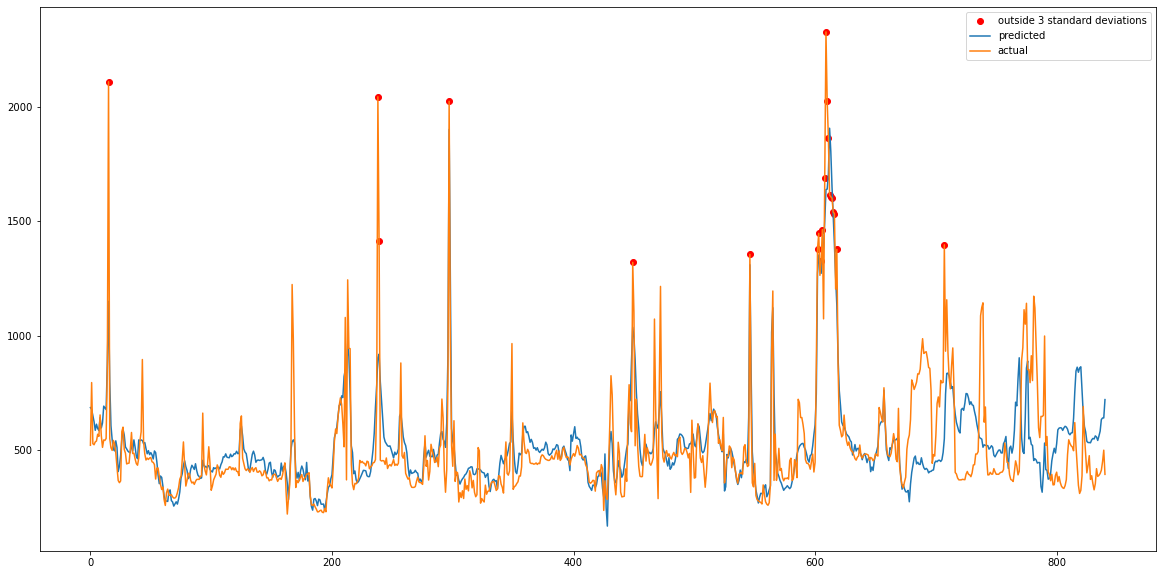

In [96]:
def nse(predictions, targets):
    return (1-(np.sum((predictions-targets)**2)/np.sum((targets-np.mean(targets))**2)))

test_dset = setter2('zscored_colorado_imz.pt','colorado_streamz.pt',841)
# test = Subset(test_dset,range(673,841))
train_dataloader = DataLoader(dataset=test_dset, batch_size=1, shuffle=False)


test_predictions = []
with torch.no_grad():
    for xx,yy in train_dataloader:
        test_pred = model(xx)
        # print(test_pred.shape)
        test_predictions.append(test_pred)

test_streamflows = [(x*dset.std)+dset.mean for x in test_predictions]
test_streamflows = torch.Tensor(test_streamflows)
test_streamflows = test_streamflows.numpy()
print(test_streamflows.shape)
# test_streamflows = np.where(test_streamflows>200000,test_streamflows,200000)
streamz_actual = torch.load('colorado_streamz.pt').numpy()
# targets = np.where(streamz_actual[:,0,0,0]>0,streamz_actual[:,0,0,0],800000)

plt.figure(figsize=(20,10))
x_ax = np.linspace(0,841,841)
y = 2 * x_ax; 


print('streamz actual mean',np.mean(streamz_actual))
print('streamz actual std',np.std(streamz_actual))
ninety_five_confidence = []
for idx,x in enumerate(streamz_actual):
#     print(x)
    if x > (np.mean(streamz_actual) + (3*np.std(streamz_actual))):
        ninety_five_confidence.append([idx,1])
#     else:
#         ninety_five_confidence.append(0)
ninety_five_confidence = np.asarray(ninety_five_confidence)


print(ninety_five_confidence.shape)
print(streamz_actual.shape)

plt.plot(ninety_five_confidence[:,0],streamz_actual[ninety_five_confidence[:,0]].reshape(-1),'ro')
# plt.plot(x_ax.reshape(-1),y.reshape(-1),'green')
plt.plot(test_streamflows)
plt.plot(streamz_actual[:,0,0,0])
plt.legend(['outside 3 standard deviations','predicted','actual'])

nse(test_streamflows,streamz_actual)

In [19]:
(test_predictions[0] * dset.std)+dset.mean

tensor([[593.8643]], device='cuda:0')

In [16]:
dset.std

tensor(254.5659)

In [17]:
dset.mean

tensor(512.2426)

In [20]:
streamz_actual[0]

array([[[521.]]], dtype=float32)